In [1]:
# # 사용 가능한 GPU 확인
# from tensorflow.python.client import device_lib
# print(device_lib.list_local_devices())

# # GPU 사용 설정
# import os
# os.environ["CUDA_VISIBLE_DEVICES"]="0"

In [2]:
# from google.colab import drive
# drive.mount('/content/drive')
# !unzip "/content/drive/MyDrive/open.zip"

In [3]:
# pip3 install tensorflow
from tensorflow.config.experimental import enable_op_determinism as tf_enable_op_determinism
from tensorflow.keras.utils import set_random_seed as keras_set_random_seed
from tensorflow.keras.layers import Flatten as keras_Flatten
from tensorflow.keras.layers import Dropout as keras_Dropout
from tensorflow.keras import Sequential as keras_Sequential
from tensorflow.keras.layers import Conv2D as keras_Conv2D
from tensorflow.keras.layers import Dense as keras_Dense
from tensorflow.keras import Input as keras_Input
from tensorflow import random as tf_random
import numpy as np
import random

# pip3 uninstall keras
# pip3 uninstall tensorflow
# pip3 install tensorflow --user

# pip3 install scikit-learn
from sklearn.model_selection import train_test_split as sklearn_train_test_split

# ------------------------------------------------

# 객체 순회 및 작업 진행률 표시
# pip3 install tqdm
from tqdm import tqdm

# 이미지 프로세싱
# pip3 install opencv-python
import cv2

# 이미지 로드 시 옵션 설정
# pip3 install pillow
from PIL import ImageFile as pil_ImageFile

# 데이터 시각화
# pip3 install matplotlib
import matplotlib.pyplot as mat_plt

# ------------------------------------------------

# 디렉토리 접근
import os
import sys

sys.path.append('/content/drive/MyDrive/Colab Notebooks/functions')
# sys.path.append(os.path.join(os.getcwd(), os.path.pardir, 'functions'))

# from 파일명 import 함수명
from get_train_list import get_train_image_paths_and_encoding_labels_fn
from predict_and_test import get_predict_result_fn, get_test_csv_fn
from get_img_tensor_v1 import get_tensor_through_imgs_fn

# pip3 install pandas
import pandas as pd

from datetime import datetime

In [4]:
# ========== 특정 파일 1개 불러와서 표시하기 ==========

# img_path = 'open/test/000.png'
# mat_plt.imshow(imread(img_path))
# mat_plt.show()

# ===================================================

In [5]:
# ======== 학습용 이미지 경로와 라벨에 대한 각각의 리스트 생성하기 ========

train_image_paths, encoding_labels = get_train_image_paths_and_encoding_labels_fn()

# =====================================================================

encoding_labels.shape : (3457, 19)


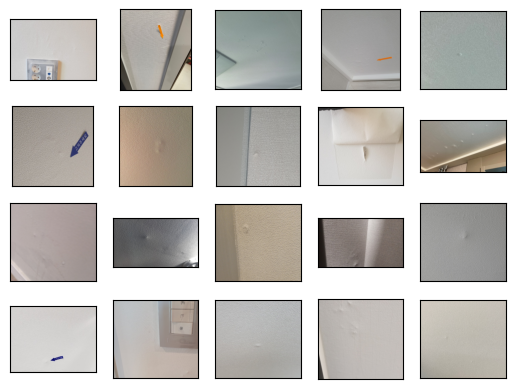

In [6]:
# ========= 학습용 이미지 리스트에서 20개만 확인해보기 =========

fig = mat_plt.figure()

# 한글 폰트 설정
# mat_plt.rc('font', family='Malgun Gothic')

for index in range(20):

    ax = fig.add_subplot(4, 5, index + 1, xticks=[], yticks=[])
    img_path = train_image_paths[index]

    # img_name = [*os.path.split(img_path)].pop()
    # defect_type = encoding_labels[index]

    # 하자 유형_이미지 파일명.확장자
    # title = f'{defect_type}_{img_name}'
    # print('title :', title)

    # ax.set_title(title, fontsize=6)

    # issue: None
    # cause: 경로에 한글이 포함될 경우 발생함
    # img = cv2.imread(img_path)

    # solved
    img_array = np.fromfile(img_path, np.uint8)
    img = cv2.imdecode(img_array, cv2.IMREAD_UNCHANGED)

    # error: (-215:Assertion failed) !_src.empty() in function 'cv::cvtColor'
    # solved: img 유무 확인하기
    ax.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))

# ============================================================


100%|██████████| 3457/3457 [01:05<00:00, 53.11it/s]


train_image_tensor.shape : (3457, 100, 100, 3)


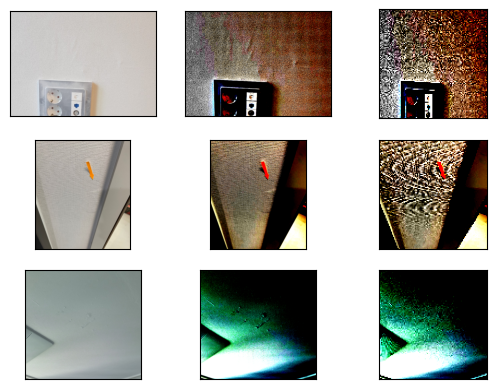

In [7]:
# ========= 교수님 코드 따라서 이미지 데이터를 가져오고 차원 변형하기 =========

# 잘린 이미지에 대한 로드 여부 설정
pil_ImageFile.LOAD_TRUNCATED_IMAGES = True

RESIZED_WIDTH = 100
RESIZED_HEIGHT = 100

fig = mat_plt.figure()

train_image_tensor = get_tensor_through_imgs_fn(train_image_paths, RESIZED_HEIGHT, RESIZED_WIDTH, fig)
print('train_image_tensor.shape :', train_image_tensor.shape)

# =========================================================================


In [8]:
# ======== 교수님의 donkey_car_CNN 코드 따라서 학습시키기 ========

# 데이콘 리더 보드 점수 => 0.299285797%

# 최종 수정 2023.05.15 (실행일 동일)
# 해당 코드는 코랩 GPU T4 고용량 RAM에서 실행시킨 결과이며 v1.2.1 버전에서 리팩토링만 진행하였음

EPOCHS = 40

# 확인 필요
SEED = 20230426
random.seed(SEED)
np.random.seed(SEED)
tf_random.set_seed(SEED)
keras_set_random_seed(SEED)
tf_enable_op_determinism()

# 학습 시킬 이미지 데이터에 대하여 정규화 (0 ~ 1)
normalized_train_image_tensor = train_image_tensor / 255
print('normalized_train_image_tensor.shape :',
      normalized_train_image_tensor.shape)

# 9:1 비율로 학습 시 사용할 데이터와 추론 시 사용할 데이터로 분리하고 랜덤성 부여
# x_for_train, x_test, y_for_train, y_test = sklearn_train_test_split(
#     normalized_image_tensor, encoding_labels, test_size=0.1)

# 9:1 비율로 학습용 데이터와 검증용 데이터로 분리
# train_data_count = int(len(x_for_train) * 0.9)
# x_valid, y_valid = x_for_train[train_data_count:], y_for_train[train_data_count:]
# x_train, y_train = x_for_train[:train_data_count], y_for_train[:train_data_count]

# train 폴더 내의 모든 이미지 데이터에 대하여 학습 진행 (1개는 학습 중에 검증용 데이터로 사용)
x_train, x_valid, y_train, y_valid = sklearn_train_test_split(
    normalized_train_image_tensor, encoding_labels, test_size=1, random_state=SEED)

model = keras_Sequential([
    keras_Input(shape=(RESIZED_WIDTH, RESIZED_HEIGHT, 3)),
    keras_Conv2D(24, (5, 5), strides=(
        2, 2), padding='same', activation='relu'),
    keras_Dropout(0.2),
    keras_Conv2D(32, (5, 5), strides=(
        2, 2), padding='same', activation='relu'),
    keras_Dropout(0.2),
    keras_Conv2D(64, (5, 5), strides=(
        2, 2), padding='same', activation='relu'),
    keras_Dropout(0.2),
    keras_Conv2D(64, (3, 3), padding='same', activation='relu'),
    keras_Dropout(0.2),
    keras_Conv2D(64, (3, 3), activation='relu'),
    keras_Dropout(0.2),
    keras_Flatten(),
    keras_Dense(100, activation='relu'),
    keras_Dropout(0.2),
    keras_Dense(50, activation='relu'),
    keras_Dropout(0.2),
    keras_Dense(19, activation='softmax'),
])

print('weights :', model.get_weights())

# Adam() 함수의 default => learning_rate=0.001,
model.compile(loss='categorical_crossentropy',
              optimizer='adam', metrics=['acc'])

print('x_train.shape :', x_train.shape)
print('y_train.shape :', y_train.shape)

# # fit() 함수의 default => batch_size = 32
history = model.fit(x_train, y_train, epochs=EPOCHS,
                    validation_data=(x_valid, y_valid))

# 연월일_시간
now = datetime.today().strftime('%Y%m%d_%H%M%S')
model.save(f'model_{now}.h5')

# =============================================


normalized_train_image_tensor.shape : (3457, 100, 100, 3)
weights : [array([[[[ 8.83265510e-02,  1.22837499e-02, -2.95881703e-02, ...,
           6.73774555e-02, -3.72010805e-02,  8.12973455e-02],
         [-9.39632207e-02,  4.45643440e-02,  6.89928010e-02, ...,
           4.26553711e-02,  3.15089151e-02,  9.26890597e-02],
         [-6.34238571e-02,  3.02844122e-02, -6.19659387e-02, ...,
           6.92132339e-02,  5.95709458e-02, -7.54594803e-05]],

        [[ 1.40569061e-02, -6.37251139e-03,  5.98601997e-03, ...,
          -6.51481971e-02,  3.24004814e-02,  7.15633705e-02],
         [-2.30382085e-02, -5.40449619e-02,  2.64575630e-02, ...,
           5.47559038e-02,  7.94376358e-02,  4.80824932e-02],
         [ 2.92287394e-02, -1.27359256e-02, -3.11992094e-02, ...,
           2.99424008e-02, -3.60852778e-02, -2.64882296e-03]],

        [[ 3.72514799e-02, -8.45330954e-03, -3.09990421e-02, ...,
           8.88911411e-02, -2.12553442e-02, -1.28627270e-02],
         [-7.69621879e-02, -4.9

loss : [2.25850510597229, 2.090608835220337, 2.0151336193084717, 1.9342669248580933, 1.8723891973495483, 1.808822751045227, 1.744376301765442, 1.6845204830169678, 1.6212164163589478, 1.562897801399231, 1.501751184463501, 1.4271650314331055, 1.342522144317627, 1.2843574285507202, 1.2201368808746338, 1.137148141860962, 1.0342612266540527, 0.9654297828674316, 0.9106109738349915, 0.9037384986877441, 0.8276249766349792, 0.7962450385093689, 0.7077469229698181, 0.6859347820281982, 0.6560911536216736, 0.5931951999664307, 0.5549331307411194, 0.5617285370826721, 0.5170915126800537, 0.4870154559612274, 0.45435795187950134, 0.4704778790473938, 0.45357704162597656, 0.3991752564907074, 0.38110944628715515, 0.39037367701530457, 0.38217809796333313, 0.3396316170692444, 0.3463245928287506, 0.31059569120407104]


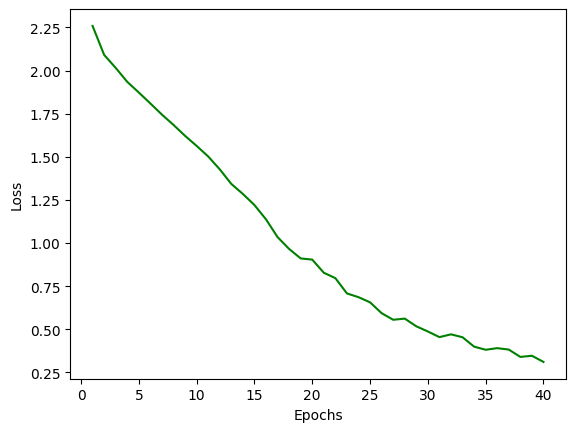

val_loss : [3.2937889099121094, 3.327119827270508, 3.27883243560791, 3.224067211151123, 2.3658015727996826, 2.649728298187256, 2.7054333686828613, 2.9911255836486816, 3.3780198097229004, 2.6105241775512695, 1.9546451568603516, 3.002880573272705, 2.4734601974487305, 2.249958038330078, 3.0605669021606445, 2.166059732437134, 2.699922561645508, 2.436945676803589, 2.044649600982666, 2.7192935943603516, 3.131061315536499, 2.1517672538757324, 2.824864625930786, 0.9554721117019653, 2.4260220527648926, 1.266229510307312, 2.3498263359069824, 4.349496841430664, 2.078705072402954, 3.7037200927734375, 2.6995508670806885, 0.9194133281707764, 4.992313385009766, 5.102724075317383, 3.6514229774475098, 3.7173845767974854, 1.2049078941345215, 4.289846897125244, 3.180271625518799, 4.030828952789307]


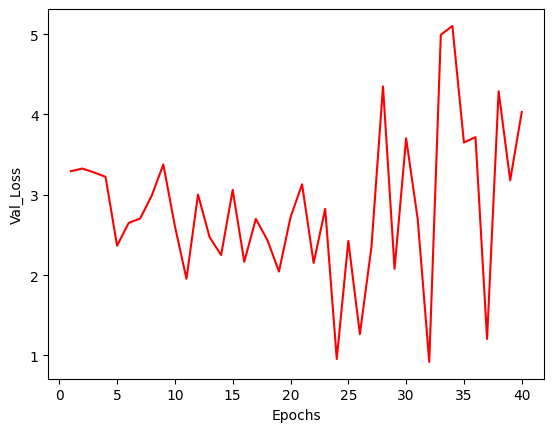

In [9]:
# ======= 학습 횟수에 따른 오차 변화 그래프 =======

loss = history.history['loss']
print('loss :', loss)

mat_plt.plot(range(1, EPOCHS + 1), loss, 'g')
mat_plt.title = 'Tranning Loss'
mat_plt.xlabel('Epochs')
mat_plt.ylabel('Loss')
mat_plt.show()

val_loss = history.history['val_loss']
print('val_loss :', val_loss)

mat_plt.plot(range(1, EPOCHS + 1), val_loss, 'r')
mat_plt.title = 'Validation Loss'
mat_plt.xlabel('Epochs')
mat_plt.ylabel('Val_Loss')
mat_plt.show()

# ===============================================

100%|██████████| 792/792 [00:15<00:00, 52.64it/s]


test_image_tensor.shape : (792, 100, 100, 3)
25/25 [==============================] - 0s 6ms/step
predicted_result.shape : (792, 19)
predicted_labels : ['걸레받이수정', '훼손', '훼손', '오염', '오염', '훼손', '들뜸', '훼손', '가구수정', '훼손', '훼손', '훼손', '걸레받이수정', '훼손', '몰딩수정', '훼손', '들뜸', '훼손', '꼬임', '훼손', '훼손', '훼손', '훼손', '훼손', '훼손', '오염', '터짐', '훼손', '훼손', '오염', '훼손', '훼손', '들뜸', '훼손', '훼손', '오염', '훼손', '오타공', '오염', '오타공', '훼손', '훼손', '훼손', '오염', '훼손', '면불량', '훼손', '훼손', '훼손', '훼손', '훼손', '훼손', '훼손', '면불량', '꼬임', '면불량', '훼손', '훼손', '훼손', '훼손', '훼손', '오염', '걸레받이수정', '훼손', '오염', '훼손', '오염', '훼손', '터짐', '오염', '훼손', '훼손', '창틀,문틀수정', '훼손', '걸레받이수정', '오염', '면불량', '오염', '오염', '오타공', '훼손', '훼손', '오염', '훼손', '오염', '훼손', '훼손', '훼손', '훼손', '훼손', '훼손', '곰팡이', '터짐', '훼손', '몰딩수정', '훼손', '훼손', '오염', '훼손', '오염', '훼손', '꼬임', '오염', '꼬임', '터짐', '훼손', '걸레받이수정', '훼손', '훼손', '오염', '훼손', '훼손', '훼손', '훼손', '훼손', '곰팡이', '오염', '오염', '훼손', '창틀,문틀수정', '훼손', '훼손', '훼손', '훼손', '석고수정', '오염', '오염', '오염', '훼손', '터짐', '훼손', '훼손', '오염', '훼

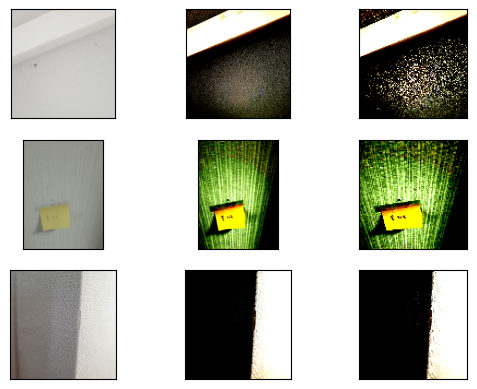

In [10]:
# ================== 테스트 파일로 추론해보기 ==================

predict_result = get_predict_result_fn(RESIZED_WIDTH, RESIZED_HEIGHT, model, 'v1')
csv_file_name = get_test_csv_fn(predict_result, 'v1_donkey_car')

# ============================================================

In [11]:
predicted_defect_types = pd.read_csv(csv_file_name)
print('predicted_defect_types :')
print(predicted_defect_types['label'].value_counts())

predicted_defect_types :
훼손         452
오염         135
꼬임          35
오타공         35
걸레받이수정      32
터짐          20
곰팡이         18
몰딩수정        16
면불량         16
가구수정         9
창틀,문틀수정      8
들뜸           6
석고수정         4
이음부불량        4
피스           1
틈새과다         1
Name: label, dtype: int64


In [2]:
# v1.2.1 csv 파일과 비교
predicted_defect_types = pd.read_csv('v1_2_1_donkey_car_test_20230429_101620.csv')
print('predicted_defect_types :')
print(predicted_defect_types['label'].value_counts())

predicted_defect_types :
label
훼손         470
오염         106
걸레받이수정      50
꼬임          33
오타공         28
곰팡이         22
터짐          20
몰딩수정        16
피스          10
면불량          8
들뜸           7
석고수정         6
가구수정         6
이음부불량        5
창틀,문틀수정      3
울음           1
녹오염          1
Name: count, dtype: int64
